In [15]:
!pip install -U bmaclient

Requirement already up-to-date: bmaclient in /home/lenovo/.local/lib/python3.8/site-packages (0.14.0)


In [16]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bmaclient import MonitoringAPI
from bmaclient.utils import get_api_key
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

import datetime as dt
import scipy
from scipy import signal
import statsmodels.api as sm

In [17]:
# BASE_DIR = os.path.dirname(os.path.abspath(__file__))
# client = MonitoringAPI(api_key='1JPZxKW5.RCpwvwK5O4T5hYFTzfPpSp9o2PdTtRwa')



def gps_data(start, end, station):
    client = MonitoringAPI(api_key='1JPZxKW5.RCpwvwK5O4T5hYFTzfPpSp9o2PdTtRwa')
    results = client.fetch_gps_position(
    timestamp__gte=start,
    timestamp__lt=end,
    station =station,
    nolimit=True,
    aggregation='mean')
    return results


In [18]:
babadan = gps_data('2022-03-01','2022-03-10','babadan')
babadan = pd.DataFrame(babadan)
babadan

,timestamp,east,north,up,err_east,err_north,err_up,orbit
0,2022-03-01T13:55:00+07:00,434984.496092,9.168033e+06,1305.510718,0.026011,0.013917,0.037881,2
1,2022-03-01T23:55:00+07:00,434984.499950,9.168033e+06,1305.511393,0.003439,0.001861,0.005137,0
2,2022-03-02T13:55:00+07:00,434984.502813,9.168033e+06,1305.497349,0.027469,0.014596,0.039728,2
3,2022-03-02T23:55:00+07:00,434984.502173,9.168033e+06,1305.500658,0.003245,0.001875,0.004878,0
4,2022-03-03T13:55:00+07:00,434984.501210,9.168033e+06,1305.499448,0.029191,0.015966,0.043309,2
5,2022-03-03T23:55:00+07:00,434984.499757,9.168033e+06,1305.499642,0.003486,0.002016,0.005044,0
6,2022-03-04T13:55:00+07:00,434984.498857,9.168033e+06,1305.476387,0.028480,0.016158,0.040596,2
7,2022-03-04T23:55:00+07:00,434984.503729,9.168033e+06,1305.495884,0.003272,0.001886,0.004970,0
8,2022-03-05T13:55:00+07:00,434984.500602,9.168033e+06,1305.489510,0.027596,0.015487,0.038925,2
9,2022-03-05T23:55:00+07:00,434984.501869,9.168033e+06,1305.495755,0.003253,0.001847,0.004715,0


In [19]:

def lin_reg(station):
    #Change timestamp data type to numerical value
    station['timestamp'] = pd.to_datetime(station['timestamp'])
    station['timestamp']=station['timestamp'].map(dt.datetime.toordinal)
    #Median filter
    station['east']= scipy.signal.medfilt(station['east'],kernel_size=3)
    station['north']= scipy.signal.medfilt(station['north'],kernel_size=3)

    #Linear Regression
    X = sm.add_constant(station['timestamp'])
    modelgx = sm.OLS(station['east'],X)
    resultsgx = modelgx.fit()
    y_predictgx = resultsgx.params[0] + resultsgx.params[1]*station['east']

    X = sm.add_constant(station['timestamp'])
    modelgy = sm.OLS(station['north'],X)
    resultsgy = modelgy.fit()
    y_predictgy = resultsgy.params[0] + resultsgy.params[1]*station['timestamp']

    return resultsgx, resultsgy

In [20]:
lin_reg(babadan)

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f0b9807db80>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f0b98d3f070>)

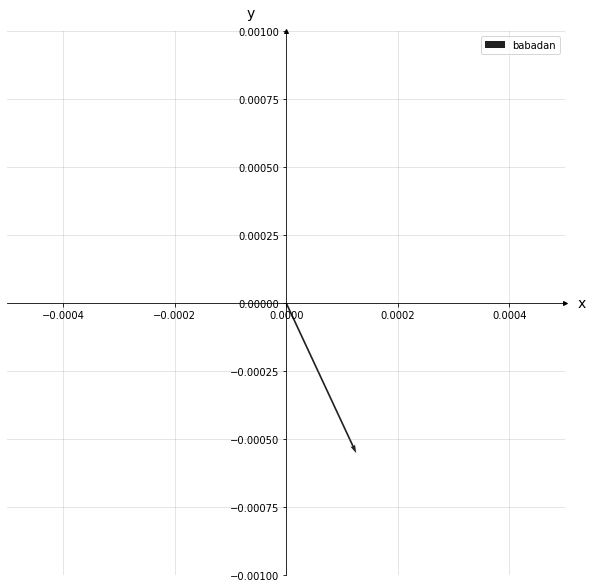

In [25]:
#Klatakan vector plot
# Select length of axes and the space between tick labels
xmin, xmax, ymin, ymax = -0.0009, 0.0009, -0.0009, 0.0009
ticks_frequency = 0.001

# Plot points
fig, ax = plt.subplots(figsize=(10, 10))


fig.add_subplot(ax)
ax.quiver(*origin, resultsgx.params[1], resultsgy.params[1], angles='xy', scale_units='xy',scale = 1, width=0.003, color='#212121', label='babadan' )
ax.set_xlim(-0.0005,0.0005)
ax.set_ylim(-0.001,0.001)

# Set bottom and left spines as x and y axes of coordinate system
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')


# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Create 'x' and 'y' labels placed at the end of the axes
ax.set_xlabel('x', size=14, labelpad=-24, x=1.03)
ax.set_ylabel('y', size=14, labelpad=-21, y=1.02, rotation=0)
ax.legend()

# Draw major and minor grid lines
ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

# Draw arrows
arrow_fmt = dict(markersize=4, color='black', clip_on=False)
ax.plot((1), (0), marker='>', transform=ax.get_yaxis_transform(), **arrow_fmt)
ax.plot((0), (1), marker='^', transform=ax.get_xaxis_transform(), **arrow_fmt)

plt.show()

In [10]:
print(resultsgy.params[1], resultsgx.params[1])

-0.0005526163149625063 0.00012556667206808925
